# Demographic Prediction from Facial Images

In [1]:
import os
import time
import imagehash
import torch
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from IPython.display import display, HTML
from IPython.display import Image as IPimage
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from Src.functions import UTKFaceDataset, plot_images_probability, lime_plots_multitask
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    r2_score,
)

params = {
    "figure.figsize": (6, 5),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "grid.alpha": 0.9,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")

# Data Cleaning

The main objectives for this part of the notebook:

- Present available data.
- Discover and address data quality issues.

## Dataset Overview

Each image path follows the format age_gender_ethnicity_path. Age is an integer from 0 to 116. Gender is either 0 (male) or 1 (female). Ethnicity is an integer from 0 to 4, representing White, Black, Asian, Indian, and Others (e.g., Hispanic, Latino, Middle Eastern). Nine random images from the dataset are presented below.

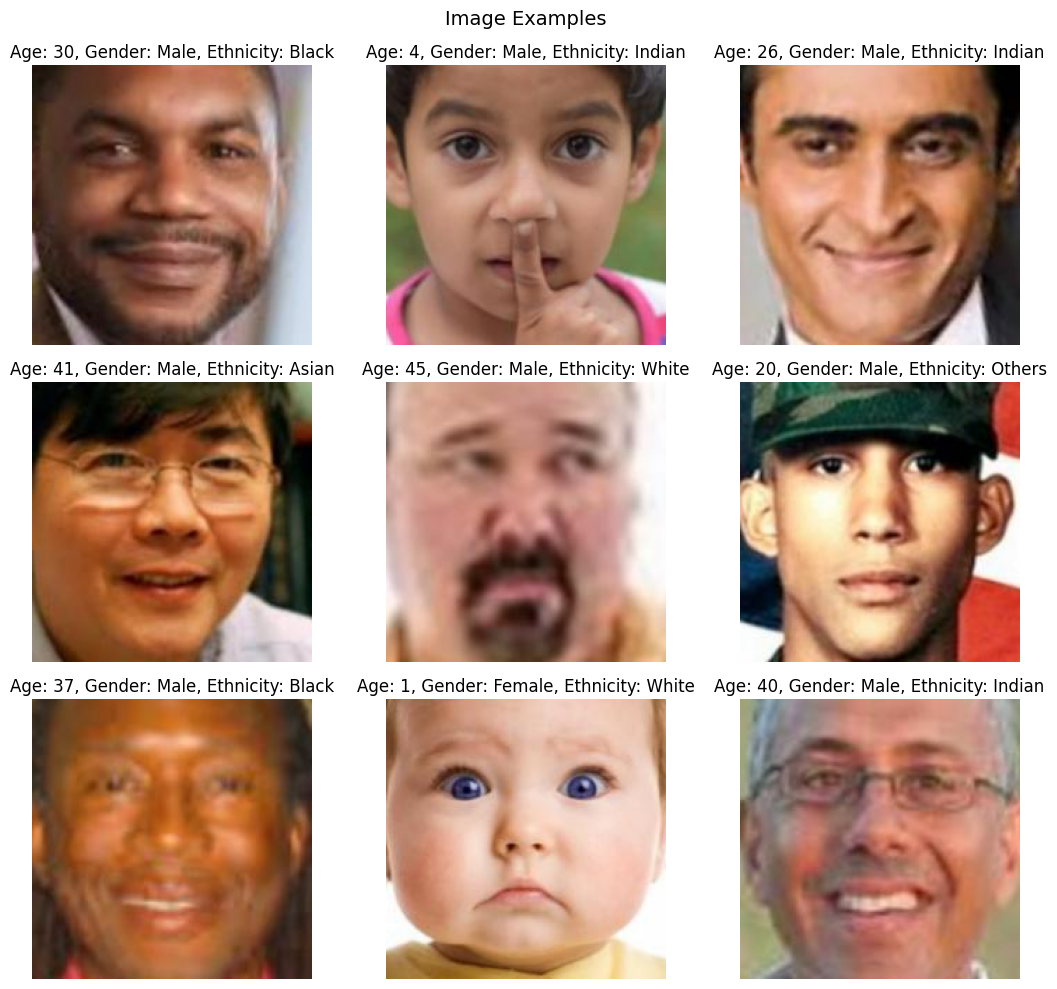

Number of pictures: 23705

Files with missing age, gender, or ethnicity label:
Skipping file: 39_1_20170116174525125.jpg.chip.jpg
Skipping file: 61_1_20170109142408075.jpg.chip.jpg
Skipping file: 61_1_20170109150557335.jpg.chip.jpg


In [2]:
data = []
missing_labels = []
for filename in os.listdir("UTKFace"):
    try:
        age, gender, ethnicity, _ = filename.split("_", 3)
        data.append(
            [os.path.join("UTKFace", filename), int(age), int(gender), int(ethnicity)]
        )
    except ValueError:
        missing_labels.append(filename)
faces = pd.DataFrame(data, columns=["image_path", "Age", "Gender", "Ethnicity"])
gender_map = {0: "Male", 1: "Female"}
ethnicity_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
faces["Gender"] = faces["Gender"].map(gender_map)
faces["Ethnicity"] = faces["Ethnicity"].map(ethnicity_map)

sample_images = faces.sample(n=9)
plt.figure(figsize=(11, 10))
plt.suptitle("Image Examples", fontsize=14, y=0.985)
for i, row in enumerate(sample_images.itertuples()):
    img = Image.open(row.image_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Age: {row.Age}, Gender: {row.Gender}, Ethnicity: {row.Ethnicity}")
plt.tight_layout()
plt.show()

print("Number of pictures:", faces.shape[0])
print("\nFiles with missing age, gender, or ethnicity label:")
for filename in missing_labels:
    print(f"Skipping file: {filename}")

- All images are close-ups of human faces, typically capturing the area from the forehead to the chin. Some of the faces are a bit rotated and a few of them have some background.
- Most pictures are of good quality, but some are blurred or pixelated, with varying sharpness and saturation.
- Three images are missing gender or ethnicity labels and will be excluded from training and evaluation.

## Anomaly Detection

I reviewed the folder containing the images to find if some of them do not depict a human faces. A more thorough review would likely find more.

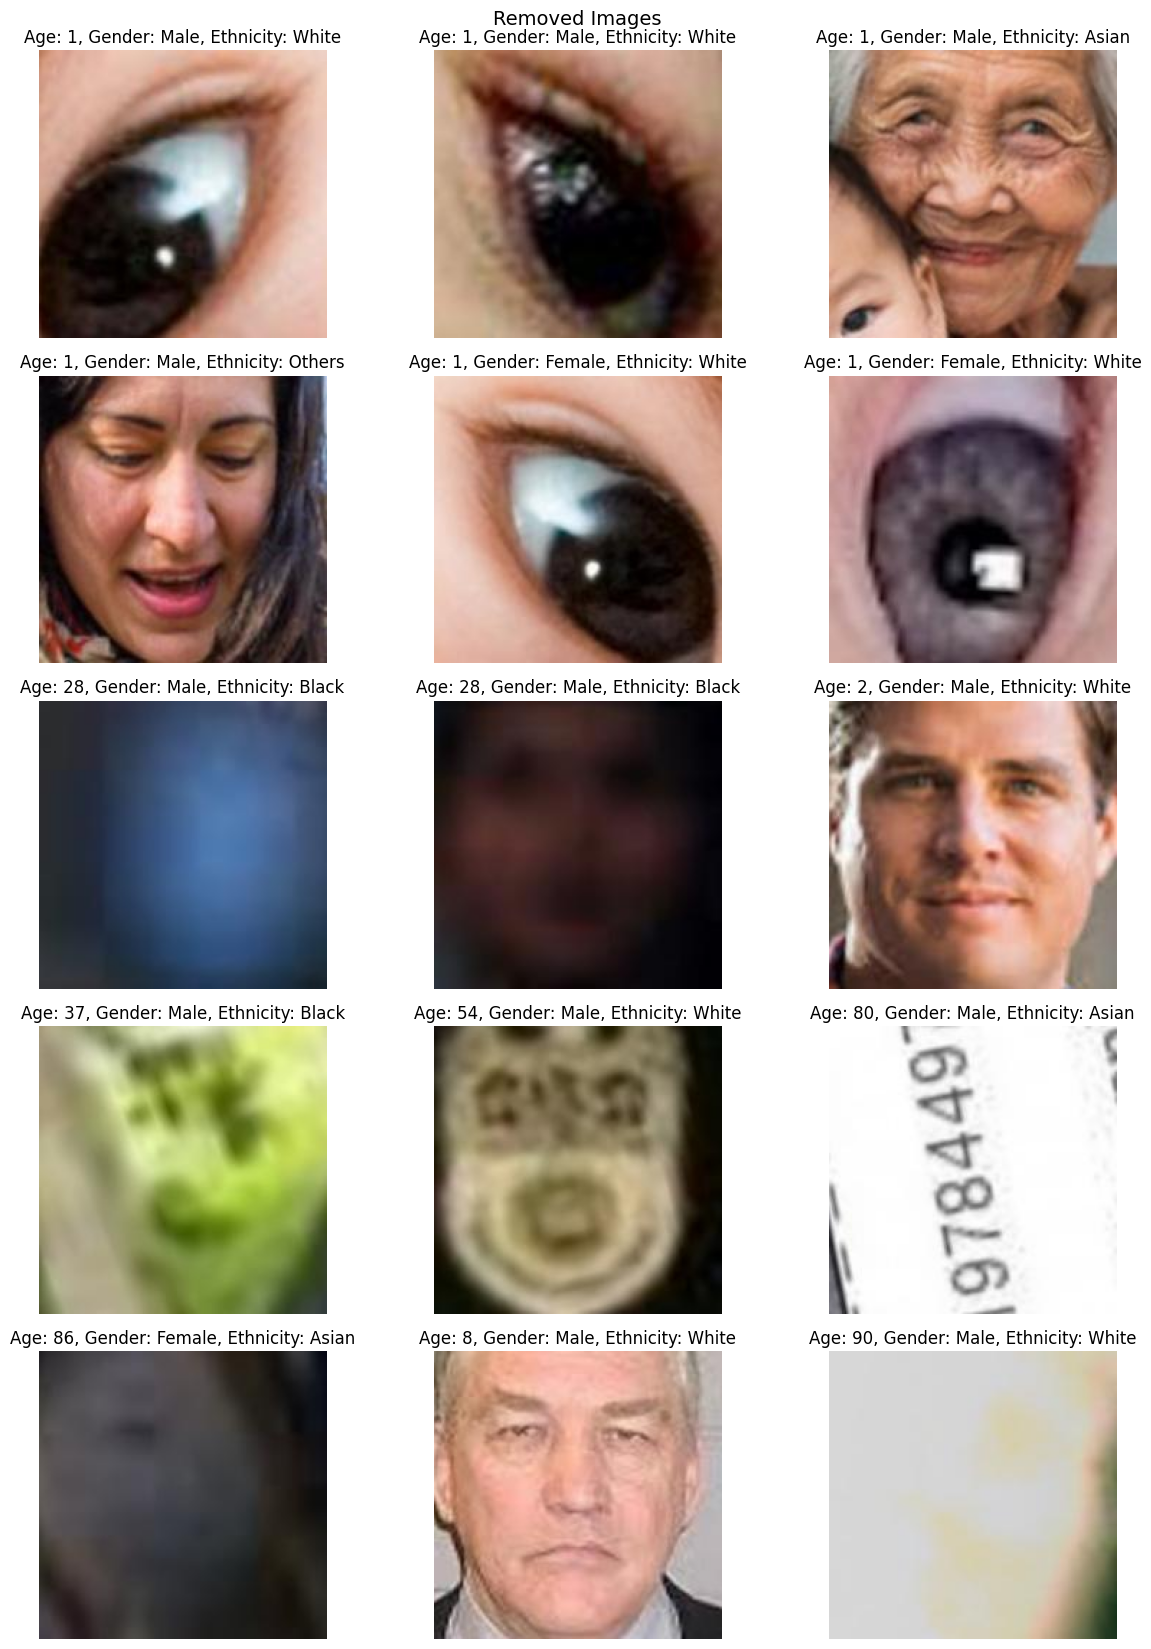

Number of removed images: 16


In [3]:
images_to_remove = [
    "1_0_0_20170109193052283.jpg.chip.jpg",
    "1_0_0_20170109194120301.jpg.chip.jpg",
    "1_0_2_20161219161843718.jpg.chip.jpg",
    "1_0_4_20161221193016140.jpg.chip.jpg",
    "1_1_0_20170109190852630.jpg.chip.jpg",
    "1_1_0_20170109194452834.jpg.chip.jpg",
    "2_0_0_20170104201100490.jpg.chip.jpg",
    "8_0_0_20170117182551223.jpg.chip.jpg",
    "28_0_1_20170117020012900.jpg.chip.jpg",
    "28_0_1_20170117202336846.jpg.chip.jpg",
    "37_0_1_20170117134417970.jpg.chip.jpg",
    "54_0_0_20170117191419939.jpg.chip.jpg",
    "54_0_0_20170117191419939.jpg.chip.jpg",
    "86_1_2_20170105174652949.jpg.chip.jpg",
    "90_0_0_20170111210338948.jpg.chip.jpg",
    "80_0_2_20170111210646563.jpg.chip.jpg",
]

remove_paths = [os.path.join("UTKFace", img) for img in images_to_remove]
plot_images = faces[faces["image_path"].isin(remove_paths)]
plt.figure(figsize=(12, 20))
plt.suptitle("Removed Images", fontsize=14, y=0.985)
for i, row in enumerate(plot_images.itertuples()):
    img = Image.open(row.image_path)
    plt.subplot(len(plot_images) // 3 + 1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Age: {row.Age}, Gender: {row.Gender}, Ethnicity: {row.Ethnicity}")
plt.tight_layout()
plt.show()
faces = faces[~faces["image_path"].isin(remove_paths)]
print("Number of removed images:", len(images_to_remove))

- Six images contained various objects.
- Four images have incorrect age labels that are visibly too low.
- Four images show an eye instead of a full face.
- One image is very heavily blurred.

## Duplicates

Perceptual hashing can recognize similar images based on their overall structure rather than individual pixel values, this includes: compression artifacts, minor cropping, small rotations, color changes, noise addition, subtle watermarking, format changes, slight blurring or sharpening, and slight perspective distortions.

I will check image dimensions, because hashing methods rely on consistent input shapes (aspect ratio).

In [4]:
unique_sizes = set()
for img_path in faces["image_path"]:
    with Image.open(img_path) as img:
        unique_sizes.add(img.size)
print("All unique image dimensions:", ", ".join(f"{w}x{h}" for w, h in unique_sizes))

All unique image dimensions: 200x200


- All images have a fixed square resolution of 200×200 pixels. Phashing will be capable of identifying duplicates without issues related to dimensional inconsistencies.

Hashing assigns each image a unique fingerprint, and the threshold defines the maximum difference allowed for two images to be considered duplicates. A higher threshold makes hashing more lenient, but also leading to more false positives. A lower threshold makes it stricter, reducing false matches but potentially missing some true duplicates. 

I have reviewed the identified duplicates at different thresholds to check if any distinct images were being incorrectly marked as duplicates.

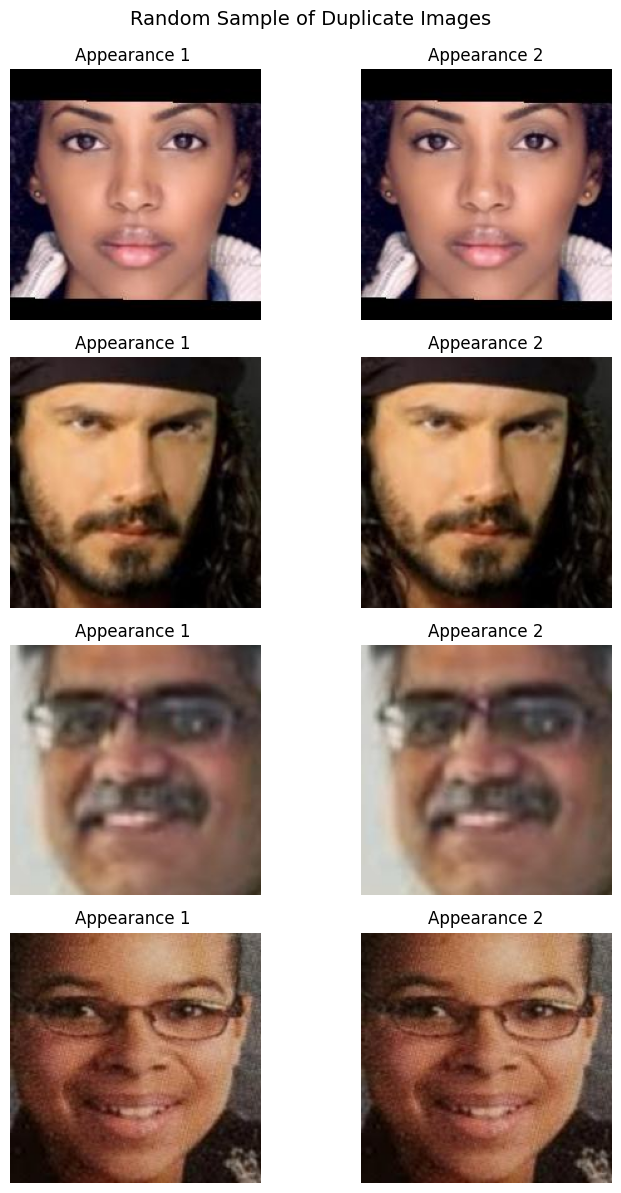

Found 878 duplicate images (excluding first occurrences).
Remaining images after duplicate removal: 22812


In [5]:
threshold = 3
duplicates_to_present = 4
hashes = {}
duplicates = []
for img_path in faces["image_path"]:
    with Image.open(img_path) as img:
        img_hash = imagehash.phash(img)
        found_duplicate = False
        for stored_hash, stored_path in hashes.items():
            if img_hash - stored_hash <= threshold:
                duplicates.append((img_path, stored_path))
                found_duplicate = True
                break
        if not found_duplicate:
            hashes[img_hash] = img_path
duplicates_df = pd.DataFrame(duplicates, columns=["Duplicate", "Original"])

sampled_duplicates = duplicates_df.sample(
    n=min(duplicates_to_present, len(duplicates_df))
)
rows = len(sampled_duplicates)
plt.figure(figsize=(8, rows * 3))
plt.suptitle("Random Sample of Duplicate Images", fontsize=14, y=0.99)
for i, row in enumerate(sampled_duplicates.itertuples()):
    for j, img_path in enumerate([row.Original, row.Duplicate]):
        plt.subplot(rows, 2, i * 2 + j + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Appearance 1 " if j == 0 else "Appearance 2", fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.2, top=0.95)
plt.tight_layout()
plt.show()

duplicate_paths = set(duplicates_df["Duplicate"])
faces = faces[~faces["image_path"].isin(duplicate_paths)]
print(f"Found {len(duplicates)} duplicate images (excluding first occurrences).")
print(f"Remaining images after duplicate removal: {len(faces)}")

- The selected threshold is 3 because raising it causes different faces with similar facial features to be incorrectly identified as duplicates on a large scale.

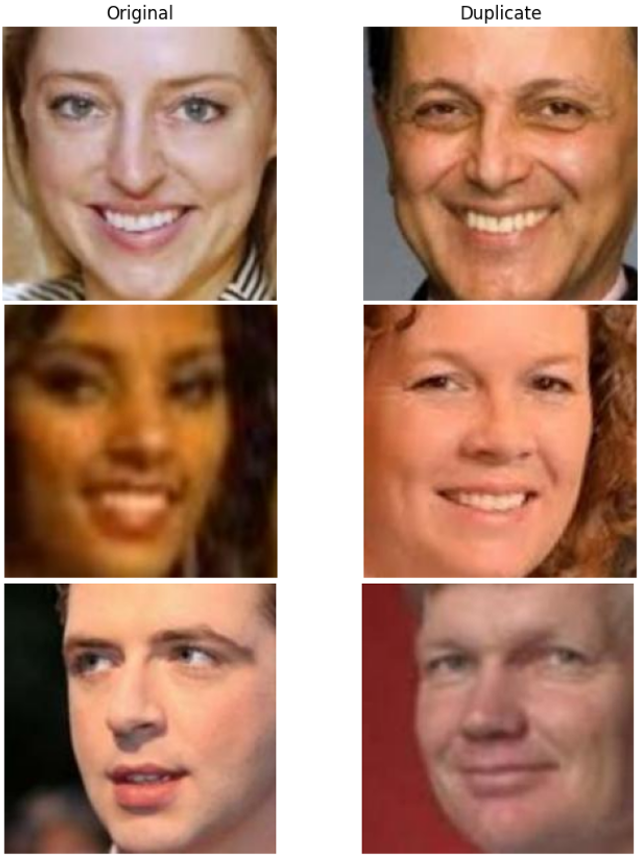

In [6]:
display(
    HTML(
        "<h3 style='margin-left: 9%; font-weight: normal;'>False Duplicate Example at Threshold of 4</h3>"
    )
)
display(IPimage("pictures/false_duplicates.png", width=600))

## Color Channels

In [7]:
mode_counts = Counter()
grayscale_count = 0
for img_path in faces["image_path"]:
    with Image.open(img_path) as img:
        mode_counts[img.mode] += 1
        if img.mode == "RGB":
            img_array = list(img.getdata())
            if all(r == g == b for r, g, b in img_array):
                grayscale_count += 1
total_images = len(faces)
for mode, count in mode_counts.items():
    print(f"Mode: {mode}, Percentage: {count / total_images * 100:.2f}%")
print(f"Grayscale images stored as RGB: {grayscale_count / total_images * 100:.2f}%")

Mode: RGB, Percentage: 100.00%
Grayscale images stored as RGB: 2.60%


- All images are encoded in RGB format. However, 2.6% of them are effectively grayscale, as all three color channels (red, green, and blue) contain identical values.

## Summary

- Three images missing gender or ethnicity labels were excluded from both training and evaluation.
- 15 anomalies were removed, including blurred images, incorrect age labels, and images showing only an eye.
- All images have a 200x200 pixel aspect ratio, so no cropping is needed for ResNet models.  
- A similarity threshold of 3 was set based on hashing distance, resulting in 878 duplicate images being removed. A higher threshold results in a large number of similar faces being identified as duplicates.
- Images are in RGB format, but 2.6% have no colors. While the model can process them, these instances may have higher error rates.  

# Exploratory Data Aanalysis

The main objectives for this part of the notebook:

- Investigate the distributions of available labels.  
- Discover bias in the data that could affect the model.

## Label Distributions

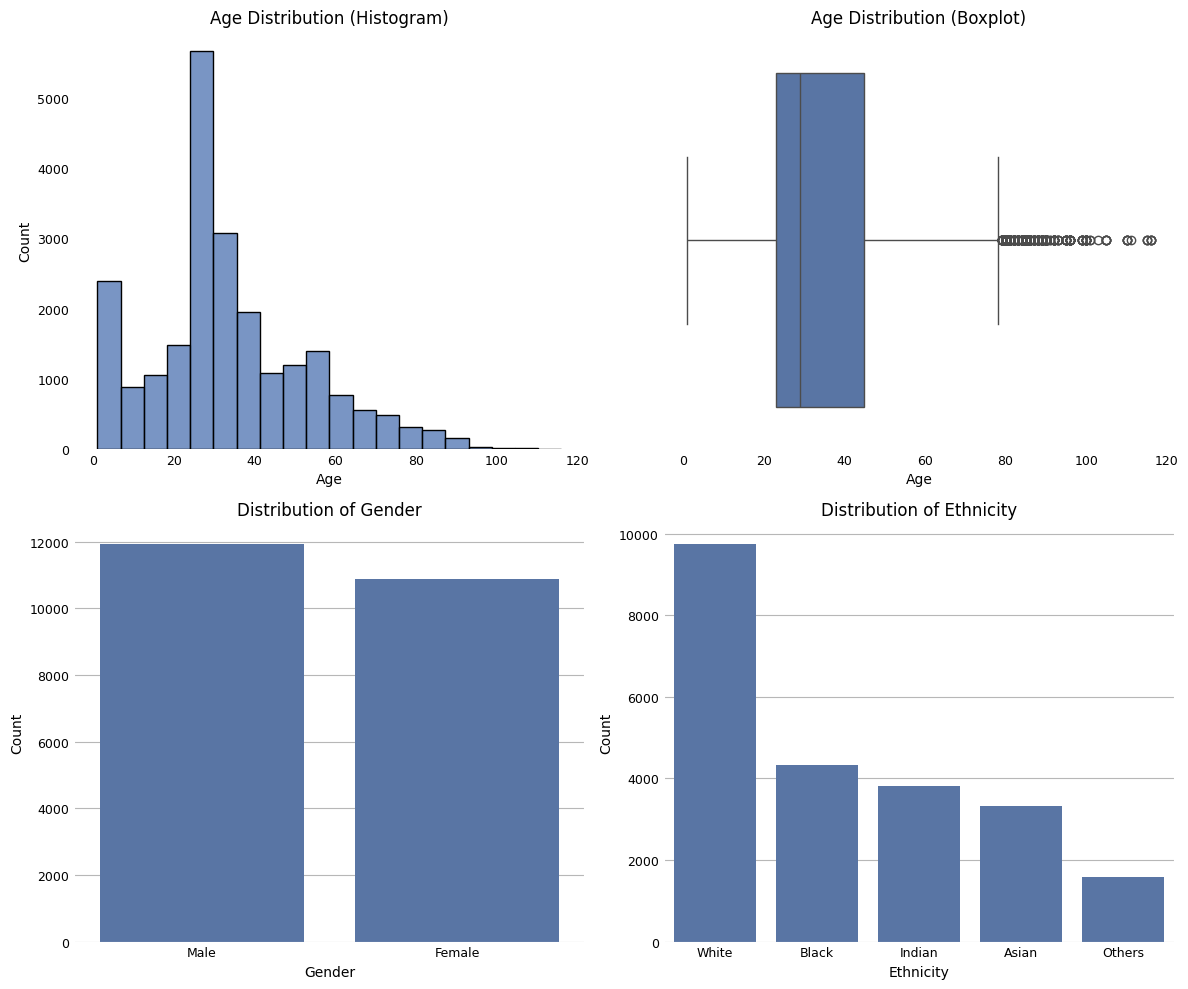

Females are 8.88% less than males.


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(faces["Age"], bins=20, zorder=5, ax=axes[0, 0])
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Age Distribution (Histogram)")
axes[0, 0].grid(False)

sns.boxplot(x=faces["Age"], ax=axes[0, 1])
axes[0, 1].set_xlabel("Age")
axes[0, 1].set_title("Age Distribution (Boxplot)")

sns.countplot(
    x=faces["Gender"],
    order=faces["Gender"].value_counts().index,
    zorder=2,
    ax=axes[1, 0],
)
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Distribution of Gender")

sns.countplot(
    x=faces["Ethnicity"],
    order=faces["Ethnicity"].value_counts().index,
    zorder=2,
    ax=axes[1, 1],
)
axes[1, 1].set_xlabel("Ethnicity")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("Distribution of Ethnicity")

plt.tight_layout()
plt.show()

warnings.simplefilter(action="ignore", category=FutureWarning)
gender_counts = faces["Gender"].value_counts()
male_count = gender_counts.get(0, 0)
female_count = gender_counts.get(1, 0)
percentage_difference = (
    ((male_count - female_count) / male_count) * 100 if male_count > 0 else 0
)
print(f"Females are {percentage_difference:.2f}% less than males.")

- The age distribution is skewed, with outliers exclusively at older ages. Using MSE instead of MAE would penalize large errors more heavily, potentially improving predictions for older individuals. However, this could come at the cost of overall performance. For marketing purposes, general accuracy is likely more important, whereas in medical applications, correctly predicting outliers might be critical. I will prioritize overall performance.
- Gender is balanced, with less than 10% difference between male and female counts. No balancing technique will be applied.
- The distribution of ethnisity is highly imbalanced, with "White" being the most represented category and "Others" the least. Since this is not a target feature, it will only be considered in error analysis.
- "Others" ethnicity has the last amount of data and the model may struggle with this group.

## Associations Between Labels

In an ideal case, the dataset would have equal amounts of different ages, genders, and ethnicities to ensure the model learns fairly from all groups.

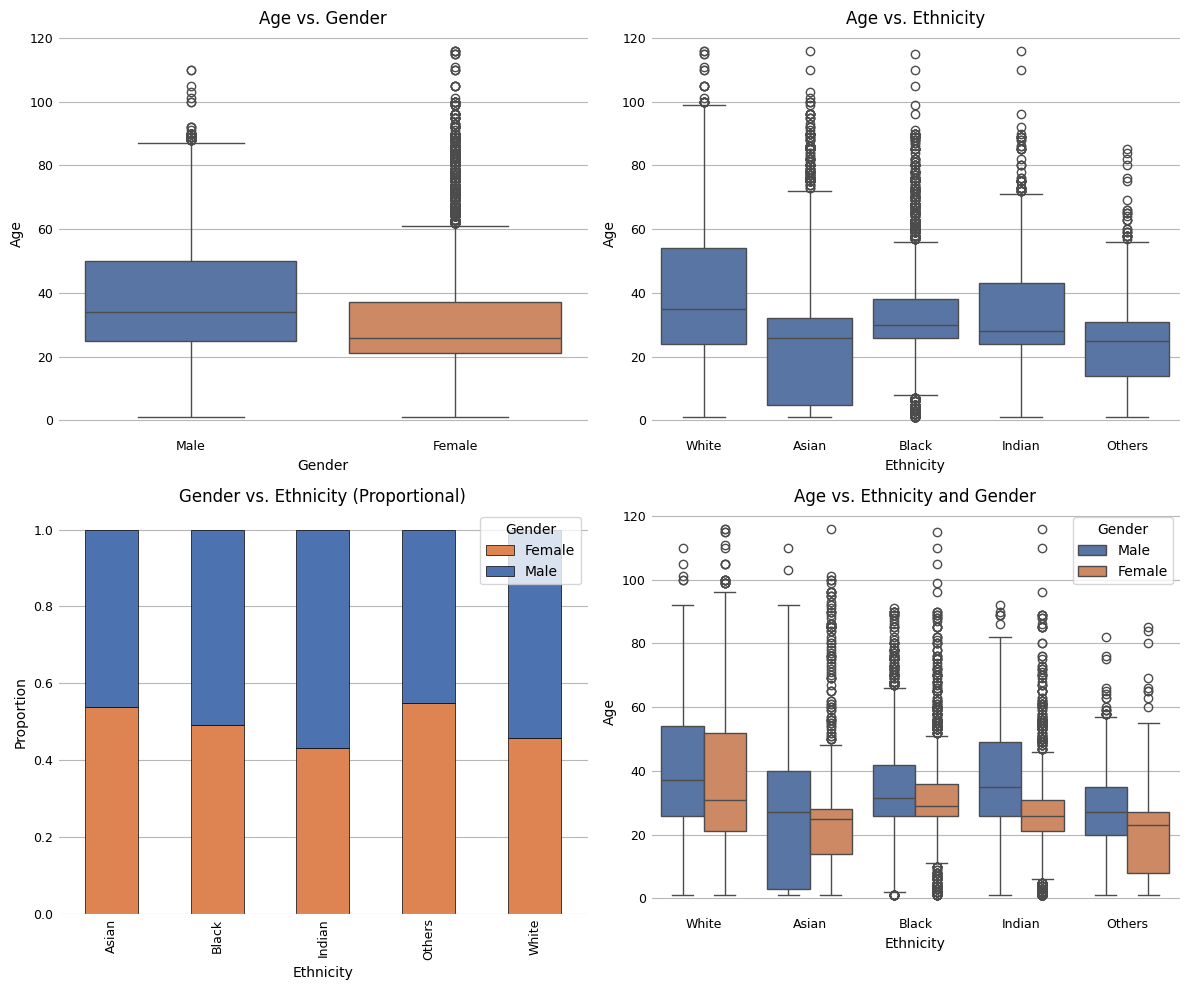

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(
    x=faces["Gender"],
    y=faces["Age"],
    ax=axes[0, 0],
    palette={"Female": "#DD8452", "Male": "#4C72B0"},
)
axes[0, 0].set_title("Age vs. Gender")

sns.boxplot(x=faces["Ethnicity"], y=faces["Age"], ax=axes[0, 1])
axes[0, 1].set_title("Age vs. Ethnicity")

crosstab = pd.crosstab(faces["Ethnicity"], faces["Gender"])
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab_normalized.plot(
    kind="bar",
    stacked=True,
    ax=axes[1, 0],
    edgecolor="black",
    linewidth=0.5,
    zorder=2,
    color=["#DD8452", "#4C72B0"],
)
axes[1, 0].set_ylabel("Proportion")
axes[1, 0].set_title("Gender vs. Ethnicity (Proportional)")
axes[1, 0].xaxis.grid(False)

sns.boxplot(x="Ethnicity", y="Age", hue="Gender", data=faces, ax=axes[1, 1])
axes[1, 1].set_title("Age vs. Ethnicity and Gender")
axes[1, 1].legend(title="Gender", loc="upper right")

plt.tight_layout()

- Older individuals tend to be male, which may lead the model to associate age-related traits (e.g., wrinkles) with being male, especially if women wear makeup.
- Asian and "Others" ethnicity groups skew younger, while White an Black individuals are generally older.
- Gender-ethnicity proportions are close to balanced. Indian and White groups have a higher male representation, "Others" tend to be more female. 
- The oldest individuals are White and Indian males, while the youngest are Asian and Indian females.  

## Summary

- The age distribution is skewed with outliers. MAE will be used instead of MSE, as accurate outlier predictions are not prioritized.  
- The gender distribution balanced and no balancing technique will be applied during modeling.  
- Men tend to be older, which contradicts real-world demographics where females have a higher median age due to longer life expectancy.  
- Asian and "Other" ethnicities are more common among younger individuals, while White individuals are generally older.
- Gender-ethnicity proportions are close to balanced.
- The oldest individuals are White and Indian males, while the youngest are Asian and Indian females.

# Deep Learning

The main objectives for this part of the notebook are:

- Fine-tune a well-performing convolutional neural network for multi-task learning.
- Evaluate and present the model's performance.
- Analyze model errors to identify areas for improvement.

To speed up computations some of the tasks will will utilize my computer's GPU.

In [10]:
print(f"CUDA available for GPU acceleration: {torch.cuda.is_available()}")
print(f"Number of NVIDIA GPUs detected: {torch.cuda.device_count()}")

CUDA available for GPU acceleration: True
Number of NVIDIA GPUs detected: 1


## Fine-Tuning

The fine-tuning process was done in a separate [Google Colab](https://colab.research.google.com/drive/1Zqxk9dxcPiNEIEffzE9jWhGDLzVFhSeB?usp=sharing) notebook to take advantage of a faster GPU. ResNet18 and ResNet34 were tested, with the final layers replaced by task-specific heads for age regression and gender classification. Training was conducted in two stages: first, training the output layer only, then fine-tuning all layers. Different learning rates and batch sizes were tested across multiple epochs, monitoring validation loss until it stopped decreasing or started increasing. These experiments were tracked as separate projects on the Weights & Biases website. Since I used the free version, I cannot make the projects public, but I have included screenshots. Results are presented only for ResNet34, as this model had slightly better performance compared to ResNet18.

- For the binary classification part of the model, "Binary Cross Entropy With Logits Loss" was used.  
- For age regression, MAE (L1) loss was used.  
- These losses were added together to form the final loss function to optimize them simultaneously.
- No class balancing was done because the difference between the two classes is small.
- Different datasets were stratified, with 70% of the data used for training, 20% for validation, and 10% for testing.
- AdamW was chosen as the optimizer since it includes weight decay for regularization, with decay set to 0.01.  
- Horizontal flip augmentation was applied to expand the available dataset.  
- I experimented with various step scheduler rates to reduce the learning rate after some fine-tuning had already happened.

### Transfer Learning

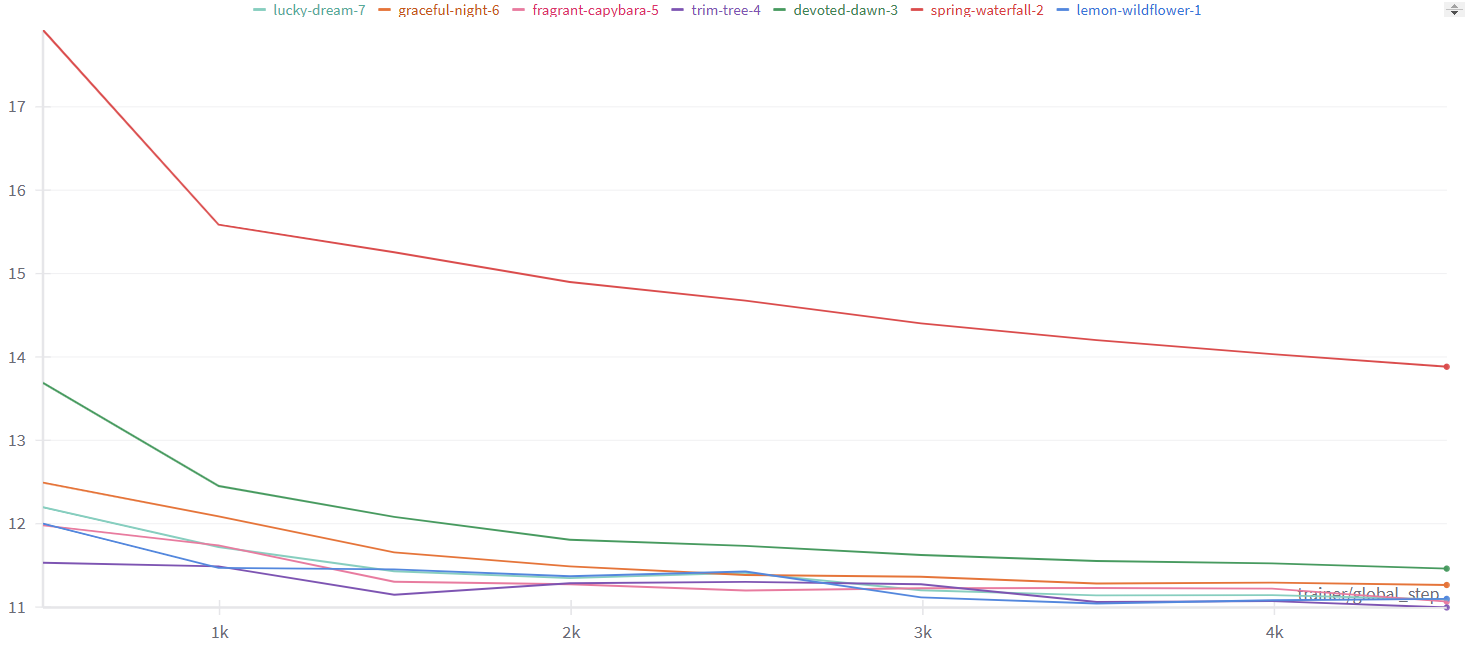

In [11]:
display(
    HTML(
        "<h3 style='margin-left: 14%; font-weight: normal;'>ResNet34 Validation Loss Progression During Transfer Learning</h3>"
    )
)
display(IPimage("Pictures/transfer_learning.png", width=1000))

- A pretrained ResNet34 model was trained with only the classification head updated and backbone frozen.
- Batch sizes of 32 were used for faster computation.
- The learning rate was set to 8e-3. Higher or lower learning rates did not reduce validation loss.
- The model was trained for 9 epochs.

The loss value after this step on the test set was 10.8. For ResNet18, it was slightly lower at 10.6.

### Fine-Tuning All Layers

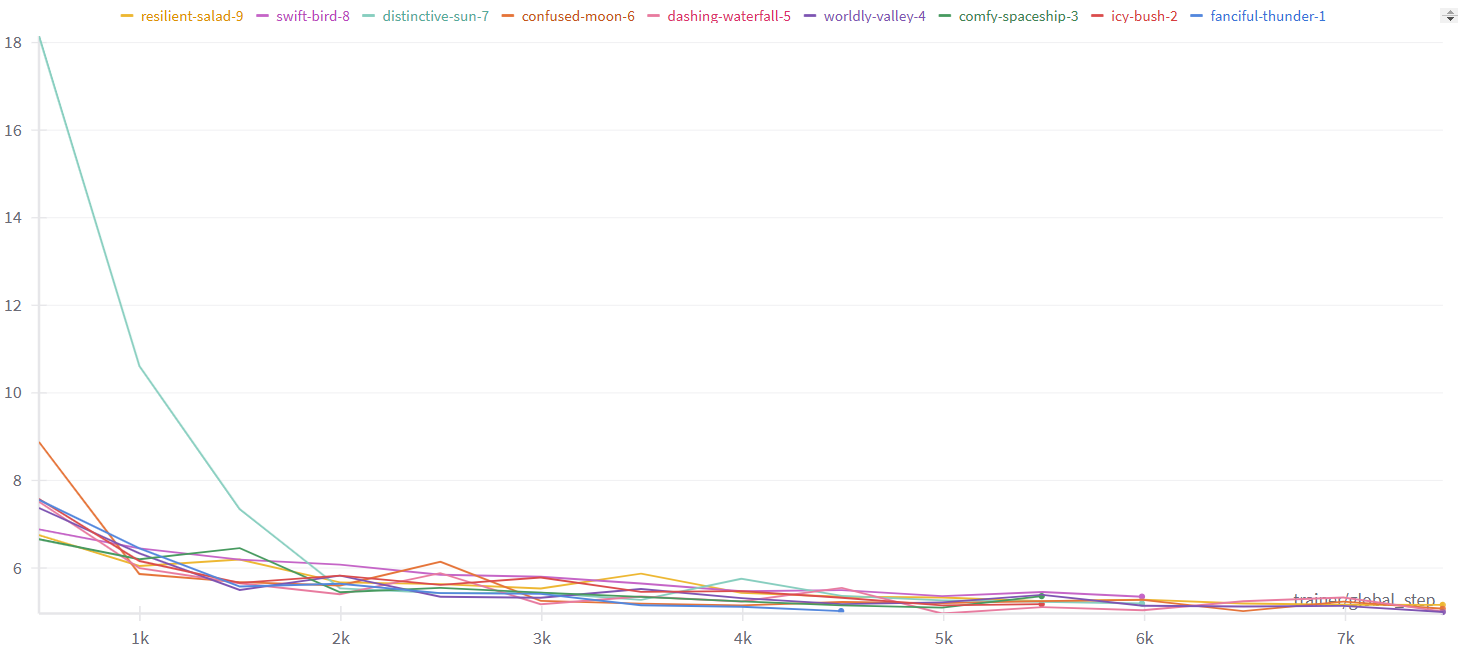

In [12]:
display(
    HTML(
        "<h3 style='margin-left: 14%; font-weight: normal;'>ResNet34 Validation Loss Progression After Unfreezing All Layers</h3>"
    )
)
display(IPimage("Pictures/fine-tuning_all.png", width=1000))

- The previously fine-tuned ResNet34 model was used as a starting point and all layers unfrozen.
- Batch sizes were reduced to 16.
- After various trials, a learning rate of 9e-5 was used for 15 epochs. Higher or lower learning rates did not reduce validation loss.
- The model was trained for 15 epochs.

The loss value on the test set was 4.8. For ResNet18, it reached 5.1.

## Preprocess and Make Predictions

The original 200x200 images are resized to 224x224 pixels without cropping. Channels are adjusted (normalized) to match the distribution expected by the pre-trained ResNet models.

In [13]:
faces["Gender"] = faces["Gender"].map({"Male": 0, "Female": 1}).fillna(faces["Gender"])
X = faces.index.values
y = faces["Gender"].values
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=5
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1 / 3, stratify=y_temp, random_state=5
)
face_predictions = faces.loc[X_test].reset_index(drop=True)
test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
batch_size = 64
test_dataset = UTKFaceDataset(face_predictions, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

loaded_model = torch.jit.load("resnet34_face_full_model.pt")
device = torch.device("cuda")
model = loaded_model.to(device)
model.eval()
all_pred_ages = []
all_gender_probs = []
batch_times = []
with torch.no_grad():
    for images, _, _ in test_loader:
        start_time = time.time()
        images = images.to(device)
        pred_age, pred_gender_logits = model(images)
        pred_gender_probs = torch.softmax(pred_gender_logits, dim=1)
        end_time = time.time()
        batch_times.append(end_time - start_time)
        all_pred_ages.append(pred_age.cpu().numpy())
        all_gender_probs.append(pred_gender_probs.cpu().numpy())
all_pred_ages = np.concatenate(all_pred_ages, axis=0).squeeze()
all_gender_probs = np.concatenate(all_gender_probs, axis=0)
avg_inference_time = np.mean(batch_times)
print(
    f"Average inference time per batch size of {batch_size}: {avg_inference_time:.3f} seconds"
)

face_predictions["Predicted Age"] = all_pred_ages
face_predictions["Predicted Gender Probs"] = [probs[1] for probs in all_gender_probs]
face_predictions["Gender"] = face_predictions["Gender"].map({0: "Male", 1: "Female"})

Average inference time per batch size of 64: 0.037 seconds


## Age Regression Performance Metrics

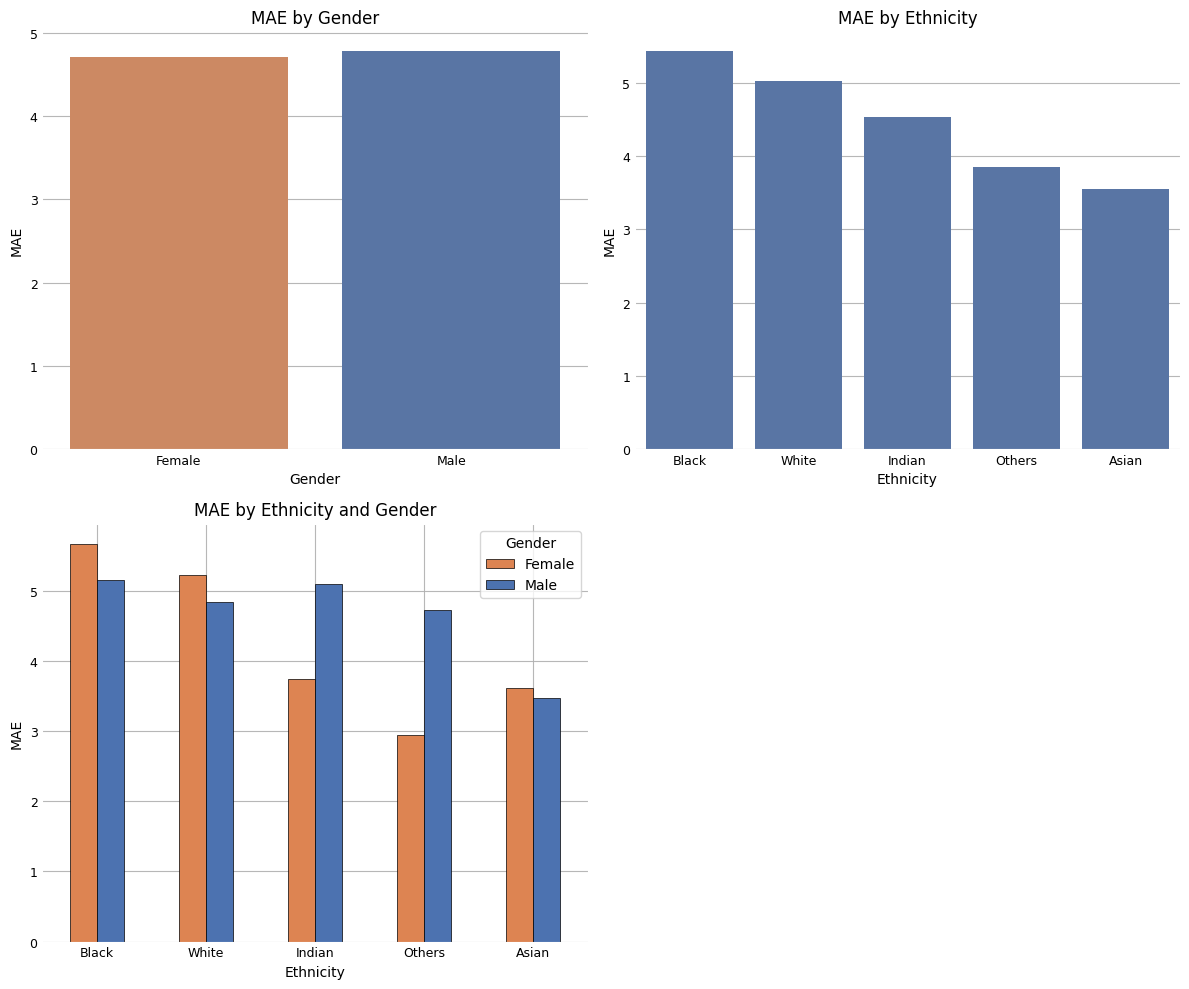

Overall MAE: 4.75
MAE for Age > 45: 8.04
MAE for Age <= 45: 3.74
Overall R²: 0.88


In [14]:
mae_overall = np.mean(
    np.abs(face_predictions["Predicted Age"] - face_predictions["Age"])
)
mae_by_gender = face_predictions.groupby("Gender")[["Predicted Age", "Age"]].apply(
    lambda df: np.mean(np.abs(df["Predicted Age"] - df["Age"]))
)
mae_by_ethnicity = face_predictions.groupby("Ethnicity")[
    ["Predicted Age", "Age"]
].apply(lambda df: np.mean(np.abs(df["Predicted Age"] - df["Age"])))
mae_by_ethnicity_sorted = mae_by_ethnicity.sort_values(ascending=False)
mae_above43 = np.mean(
    np.abs(
        face_predictions.loc[face_predictions["Age"] > 45, "Predicted Age"]
        - face_predictions.loc[face_predictions["Age"] > 45, "Age"]
    )
)
mae_below43 = np.mean(
    np.abs(
        face_predictions.loc[face_predictions["Age"] <= 45, "Predicted Age"]
        - face_predictions.loc[face_predictions["Age"] <= 45, "Age"]
    )
)
r2_overall = r2_score(face_predictions["Age"], face_predictions["Predicted Age"])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.barplot(
    x=mae_by_gender.index,
    y=mae_by_gender.values,
    ax=axes[0, 0],
    palette=["#DD8452", "#4C72B0"],
    zorder=2,
)
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("MAE")
axes[0, 0].set_title("MAE by Gender")

sns.barplot(
    x=mae_by_ethnicity_sorted.index,
    y=mae_by_ethnicity_sorted.values,
    ax=axes[0, 1],
    zorder=2,
)
axes[0, 1].set_xlabel("Ethnicity")
axes[0, 1].set_ylabel("MAE")
axes[0, 1].set_title("MAE by Ethnicity")

mae_eth_gender = (
    face_predictions.groupby(["Ethnicity", "Gender"])[["Predicted Age", "Age"]]
    .apply(lambda df: np.mean(np.abs(df["Predicted Age"] - df["Age"])))
    .reset_index(name="MAE")
)
pivot = mae_eth_gender.pivot(index="Ethnicity", columns="Gender", values="MAE")
pivot = pivot.reindex(pivot.sum(axis=1).sort_values(ascending=False).index)
if set(pivot.columns) == {"Female", "Male"}:
    pivot = pivot[["Female", "Male"]]
pivot.plot(
    kind="bar",
    ax=axes[1, 0],
    edgecolor="black",
    linewidth=0.5,
    zorder=2,
    color=["#DD8452", "#4C72B0"],
)
axes[1, 0].set_xlabel("Ethnicity")
axes[1, 0].set_ylabel("MAE")
axes[1, 0].set_title("MAE by Ethnicity and Gender")
axes[1, 0].legend(title="Gender", loc="upper right")
axes[1, 0].tick_params(axis="x", rotation=0)

axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

print(f"Overall MAE: {mae_overall:.2f}")
print(f"MAE for Age > 45: {mae_above43:.2f}")
print(f"MAE for Age <= 45: {mae_below43:.2f}")
print(f"Overall R²: {r2_overall:.2f}")

- The average error is 4.75 years. This is not a significant issue, as applications like targeted marketing likely do not require highly accurate age predictions.  
- Different Ethnicities are predicted with variations of approximately ±1 year form the ovrall MAE. Black group is the least accurate, eith MAE of 5.4.
- Based on two feature associations, age appears to be predicted equally well for both genders, showing no bias. However, when ethnicity is considered as a third dimension, it becomes clear that for Indian and "Other" groups, males have an MAE higher by around 2 and 1 years, respectively.
- As will be seen in the residual plot, the model performs worse for older individuals. The average error (MAE) is 8 years for those over 45, while for younger individuals (45 and below), it is 3.7 years. The age of 45 was chosen as the threshold because it is the third quartile.

I could further assess whether the mistakes consistently lean in a particular direction, indicating model bias. However, the impact may not be significant if high precision is not required.  

## Age Residual Analysis

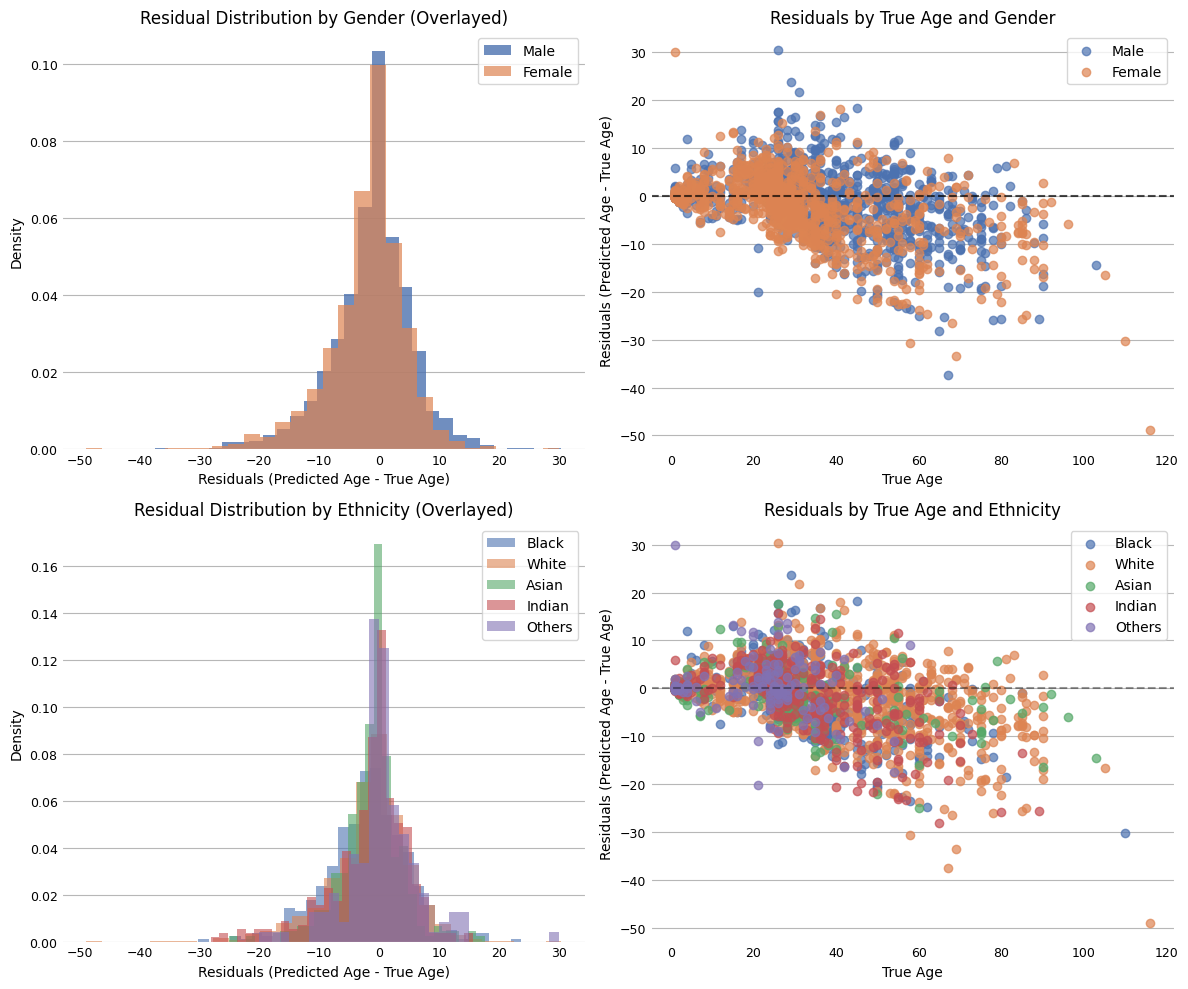

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
face_predictions["Residuals"] = (
    face_predictions["Predicted Age"] - face_predictions["Age"]
)
ethnicities = face_predictions["Ethnicity"].unique()

axes[0, 0].hist(
    face_predictions["Residuals"][face_predictions["Gender"] == "Male"],
    bins=30,
    alpha=0.8,
    color="#4C72B0",
    label="Male",
    density=True,
    zorder=2,
)
axes[0, 0].hist(
    face_predictions["Residuals"][face_predictions["Gender"] == "Female"],
    bins=30,
    alpha=0.7,
    color="#DD8452",
    label="Female",
    density=True,
    zorder=2,
)
axes[0, 0].set_xlabel("Residuals (Predicted Age - True Age)")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("Residual Distribution by Gender (Overlayed)")
axes[0, 0].legend()

for gender, col in zip(["Male", "Female"], ["#4C72B0", "#DD8452"]):
    subset = face_predictions[face_predictions["Gender"] == gender]
    axes[0, 1].scatter(
        subset["Age"],
        subset["Predicted Age"] - subset["Age"],
        label=gender,
        alpha=0.7,
        color=col,
        zorder=2,
    )
axes[0, 1].axhline(0, color="black", linestyle="dashed", alpha=0.7)
axes[0, 1].set_xlabel("True Age")
axes[0, 1].set_ylabel("Residuals (Predicted Age - True Age)")
axes[0, 1].set_title("Residuals by True Age and Gender")
axes[0, 1].legend()

colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B3"]
for eth, col in zip(ethnicities, colors):
    axes[1, 0].hist(
        face_predictions["Residuals"][face_predictions["Ethnicity"] == eth],
        bins=30,
        alpha=0.6,
        color=col,
        label=eth,
        density=True,
        zorder=2,
    )
axes[1, 0].set_xlabel("Residuals (Predicted Age - True Age)")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("Residual Distribution by Ethnicity (Overlayed)")
axes[1, 0].legend()

for eth, col in zip(ethnicities, colors):
    subset = face_predictions[face_predictions["Ethnicity"] == eth]
    axes[1, 1].scatter(
        subset["Age"],
        subset["Predicted Age"] - subset["Age"],
        label=eth,
        alpha=0.7,
        color=col,
        zorder=2,
    )
axes[1, 1].axhline(0, color="black", linestyle="dashed", alpha=0.4)
axes[1, 1].set_xlabel("True Age")
axes[1, 1].set_ylabel("Residuals (Predicted Age - True Age)")
axes[1, 1].set_title("Residuals by True Age and Ethnicity")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

- The histogram shows that most residuals are centered around zero, but the left skew indicates that overestimation is more frequent than underestimation.  
- The scatter plot clarifies this, making visible that younger individuals age is generally predicted close to the true value, but the model tends to underpredict for older ages accross all genders and ethnicities.
- The model struggles the most with extreme age values, often predicting much higher than the actual age.  
- This could be partially explained by differences in aging, as some individuals may appear older or younger than their actual age depending on their level of self-care.  

From the overlaid information, it does not appear that the model is making systematic errors for gender or ethnicity in a particular direction. However, to thoroughly check, the plots would need to be separated and inspected individually.  

## Reviewing Regression High-Error Predictions

 The goal is to see if certain characteristics, such as mislabeling, image quality, or specific facial traits, contribute to larger prediction errors. For conciseness, only the first nine error occurrences in the dataset are presented. 

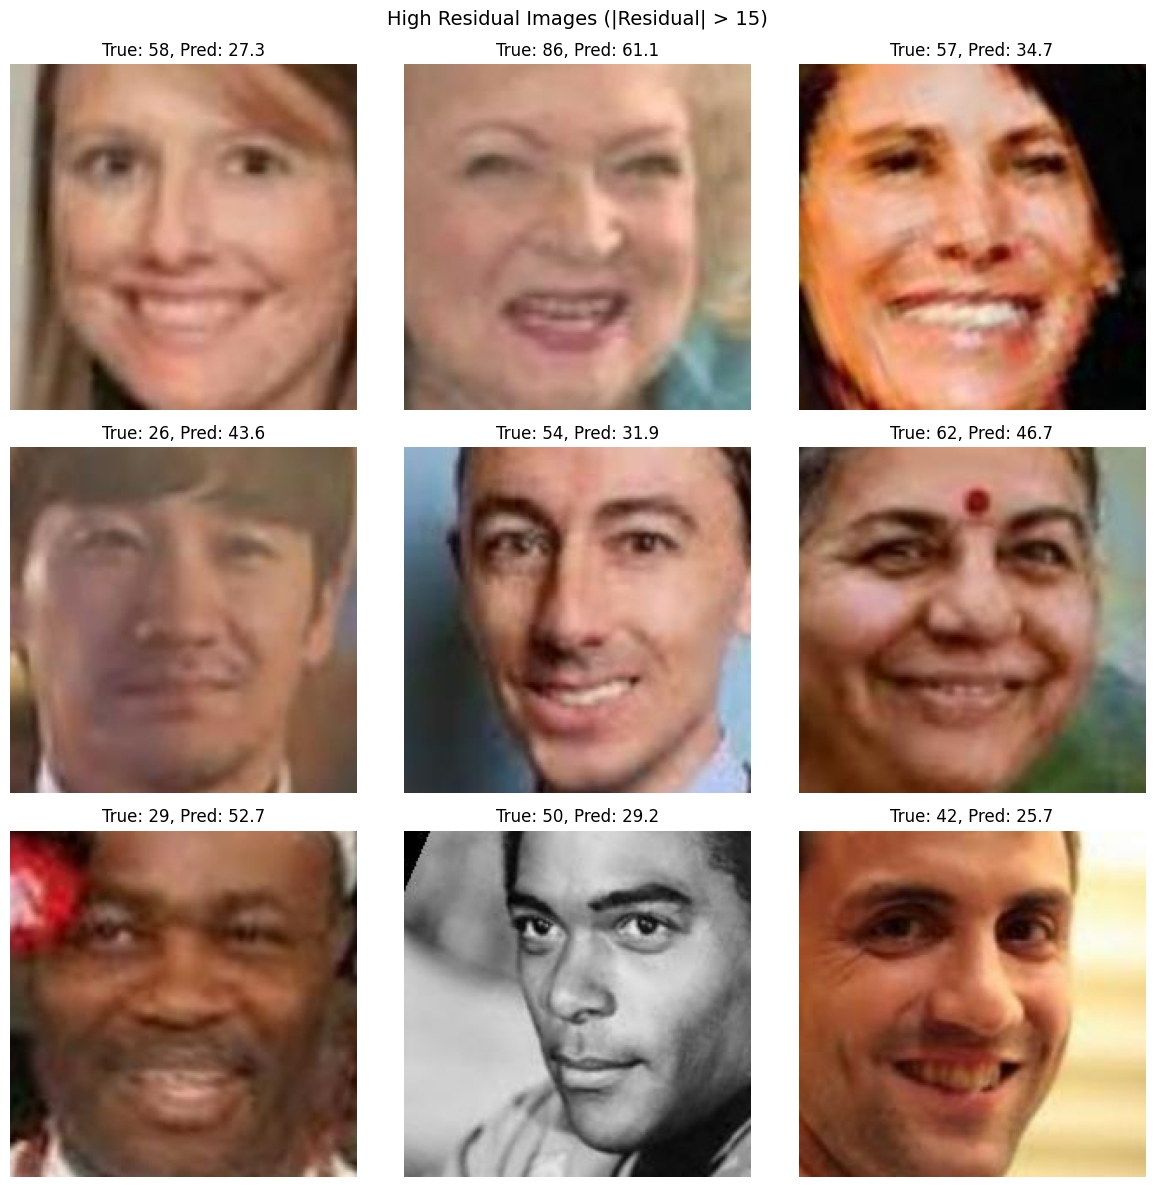

In [16]:
residual_threshold = 15
number_of_rows_display = 3
high_residuals = face_predictions[
    np.abs(face_predictions["Residuals"]) > residual_threshold
]
num_rows = min(number_of_rows_display, -(-len(high_residuals) // 3))
figsize = (12, num_rows * 4)
plt.figure(figsize=figsize)
plt.suptitle(
    f"High Residual Images (|Residual| > {residual_threshold})", fontsize=14, y=0.985
)
for i, row in enumerate(high_residuals.itertuples()):
    if i >= num_rows * 3:
        break
    img = Image.open(row.image_path)
    plt.subplot(num_rows, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {row.Age}, Pred: {row._5:.1f}")
plt.tight_layout()
plt.show()

- Some true age labels are suspicious and may be incorrect.  
- Most errors, as expected from the previous section, come from underpredicted older faces.  
- People age unevenly, which may explain some mispredictions. Even for the human eye, estimating exact age from a picture is difficult, especially with factors like makeup.  
- This is not an image quality issue, as the images are of reasonably good quality.  

Overall nothing unexpected stood out.

## Gender Classification Performance Metrics

I will select the threshold that maximizes both precision and recall by choosing the highest F1-score across all thresholds.  

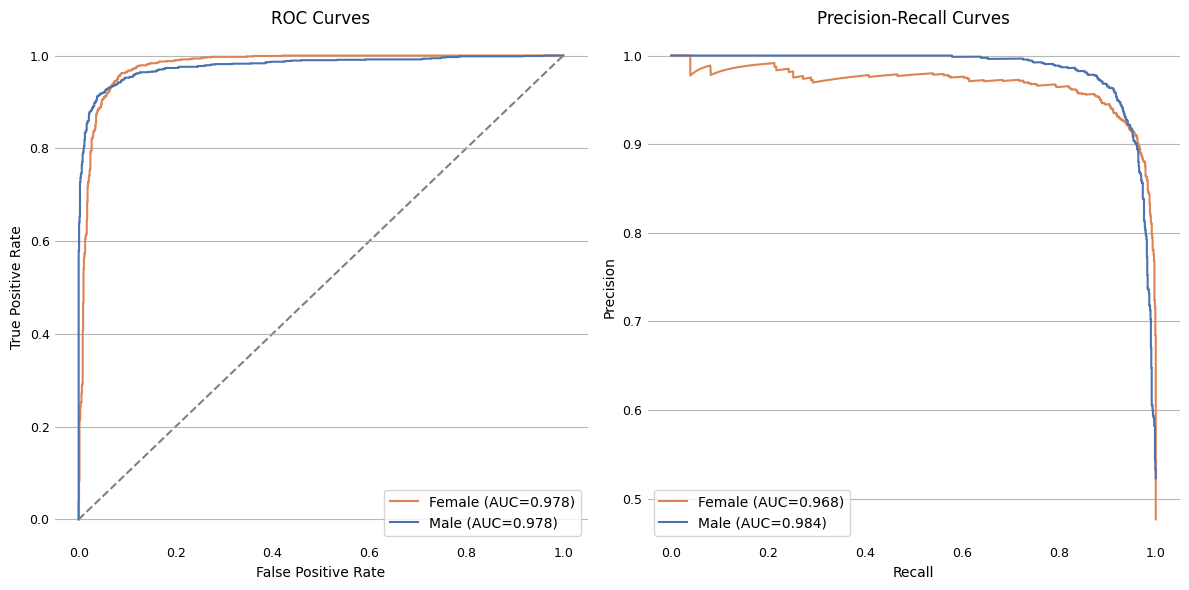

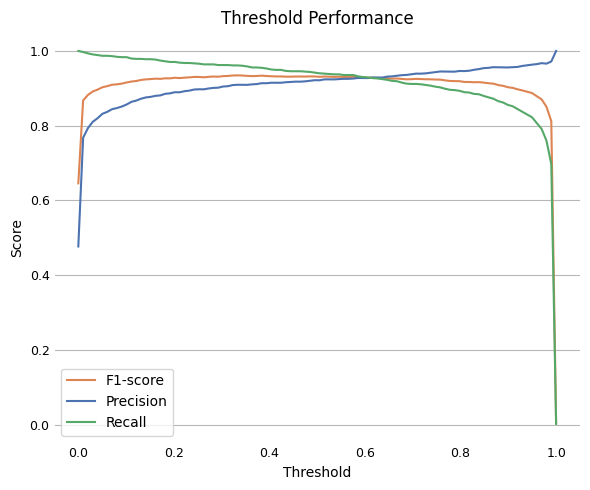

Best threshold for highest F1-score: 0.333


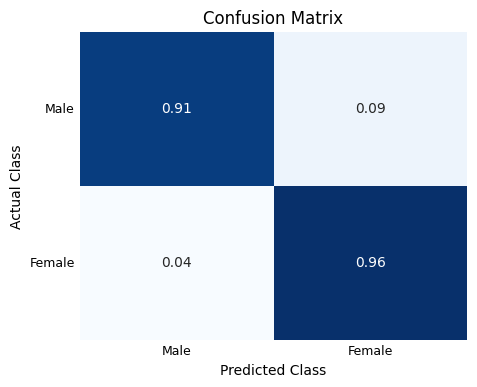

Accuracy (all data): 0.936
Accuracy (Age >= 3): 0.956


In [17]:
face_predictions_orig = face_predictions.copy()
y_true_all = (face_predictions_orig["Gender"] == "Female").astype(int)
y_probs_all = face_predictions_orig["Predicted Gender Probs"].values
fpr_female, tpr_female, _ = roc_curve(y_true_all, y_probs_all)
fpr_male, tpr_male, _ = roc_curve(1 - y_true_all, 1 - y_probs_all)
roc_auc_female = auc(fpr_female, tpr_female)
roc_auc_male = auc(fpr_male, tpr_male)
precision_female, recall_female, _ = precision_recall_curve(y_true_all, y_probs_all)
precision_male, recall_male, _ = precision_recall_curve(1 - y_true_all, 1 - y_probs_all)
pr_auc_female = auc(recall_female, precision_female)
pr_auc_male = auc(recall_male, precision_male)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(
    fpr_female,
    tpr_female,
    label=f"Female (AUC={roc_auc_female:.3f})",
    color="#DD8452",
    zorder=2,
)
axes[0].plot(
    fpr_male,
    tpr_male,
    label=f"Male (AUC={roc_auc_male:.3f})",
    color="#4C72B0",
    zorder=2,
)
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray", zorder=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves")
axes[0].legend()
axes[1].plot(
    recall_female,
    precision_female,
    label=f"Female (AUC={pr_auc_female:.3f})",
    color="#DD8452",
    zorder=2,
)
axes[1].plot(
    recall_male,
    precision_male,
    label=f"Male (AUC={pr_auc_male:.3f})",
    color="#4C72B0",
    zorder=2,
)
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves")
axes[1].legend()
plt.tight_layout()
plt.show()

thresholds = np.linspace(0.0, 1.0, 100)
f1_scores = np.array(
    [f1_score(y_true_all, (y_probs_all >= t).astype(int)) for t in thresholds]
)
precisions = np.array(
    [precision_score(y_true_all, (y_probs_all >= t).astype(int)) for t in thresholds]
)
recalls = np.array(
    [recall_score(y_true_all, (y_probs_all >= t).astype(int)) for t in thresholds]
)
plt.figure(figsize=(6, 5))
plt.plot(thresholds, f1_scores, label="F1-score", color="#DD8452", zorder=2)
plt.plot(thresholds, precisions, label="Precision", color="#4C72B0", zorder=2)
plt.plot(thresholds, recalls, label="Recall", color="#55A868", zorder=2)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Performance")
plt.legend()
plt.tight_layout()
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for highest F1-score: {best_threshold:.3f}")

y_pred_all = (y_probs_all >= best_threshold).astype(int)
cm_all = confusion_matrix(y_true_all, y_pred_all, normalize="true")
plt.figure(figsize=(5, 4))
sns.heatmap(cm_all, annot=True, fmt=".2f", cmap="Blues", cbar=False, zorder=2)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0.5, 1.5], labels=["Male", "Female"])
plt.yticks(ticks=[0.5, 1.5], labels=["Male", "Female"], rotation=0)
plt.show()
report_all = classification_report(
    y_true_all, y_pred_all, target_names=["Male", "Female"], output_dict=True
)
df_report_all = pd.DataFrame(report_all).transpose()
accuracy_all = df_report_all.loc["accuracy", "precision"]

face_predictions_filtered = face_predictions_orig[face_predictions_orig["Age"] >= 3]
y_true_filtered = (face_predictions_filtered["Gender"] == "Female").astype(int)
y_probs_filtered = face_predictions_filtered["Predicted Gender Probs"].values
y_pred_filtered = (y_probs_filtered >= best_threshold).astype(int)
report_filtered = classification_report(
    y_true_filtered, y_pred_filtered, target_names=["Male", "Female"], output_dict=True
)
df_report_filtered = pd.DataFrame(report_filtered).transpose()
accuracy_filtered = df_report_filtered.loc["accuracy", "precision"]

print(
    f"Accuracy (all data): {accuracy_all:.3f}\nAccuracy (Age >= 3): {accuracy_filtered:.3f}"
)

- The model is performing well, with a high ROC-AUC score of 0.96 and an accuracy of 0.93. 
- While reviewing the errors, I noticed that very young children are hard to classify accurately, even for humans. After excluding this data, the accuracy increases to 0.95.

## Predicted Probabilities

My convention is that high predicted probability corresponds to the model classifying an individual as female, while a low probability indicates a classification as male.

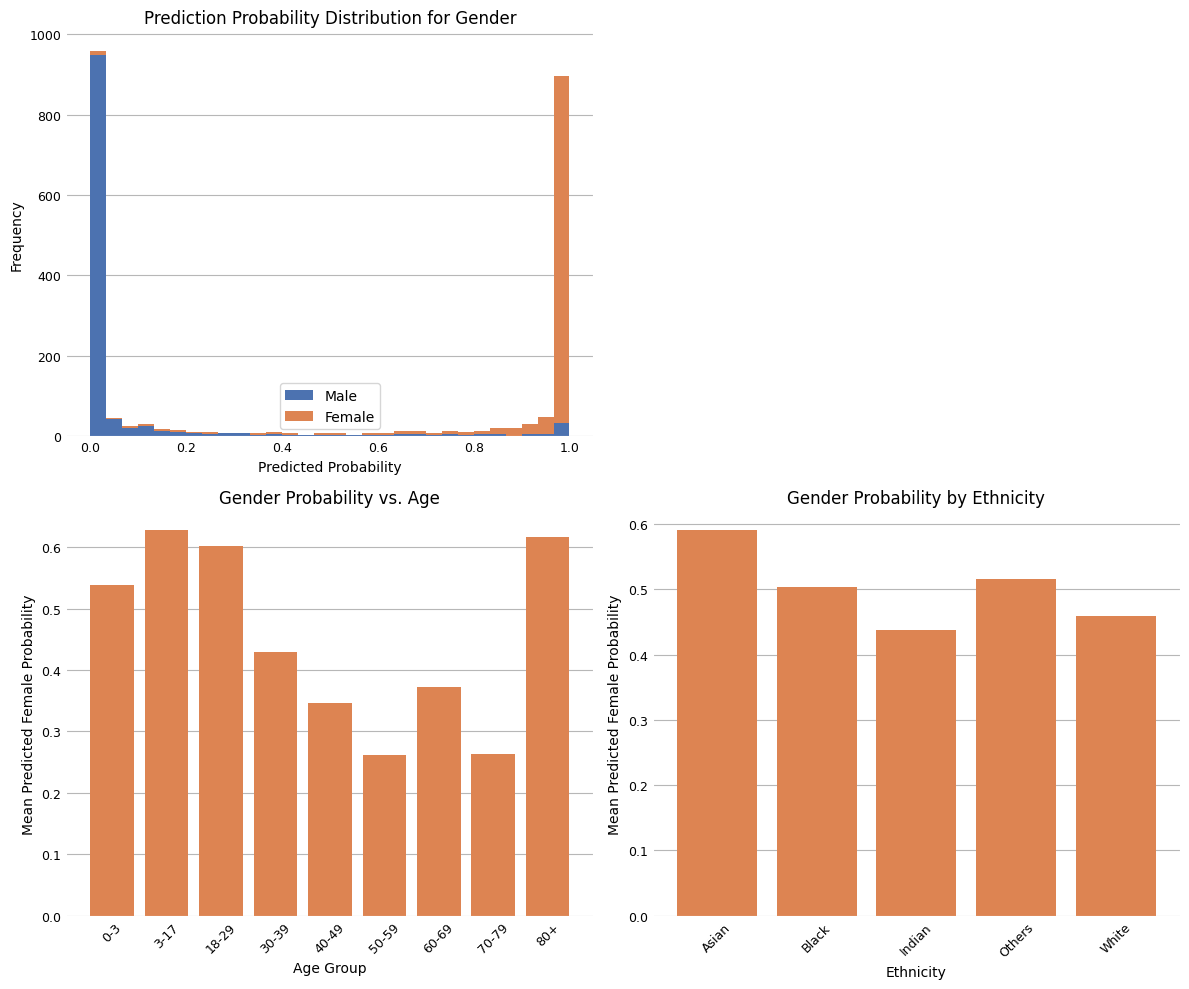

In [18]:
bins = [0, 3, 18, 30, 40, 50, 60, 70, 80, np.inf]
labels = ["0-3", "3-17", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
face_predictions["Age Bin"] = pd.cut(
    face_predictions["Age"], bins=bins, labels=labels, right=False
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1]})
probs_female = face_predictions.loc[
    face_predictions["Gender"] == "Female", "Predicted Gender Probs"
]
probs_male = face_predictions.loc[
    face_predictions["Gender"] == "Male", "Predicted Gender Probs"
]

axes[0, 0].hist(
    [probs_male, probs_female],
    stacked=True,
    color=["#4C72B0", "#DD8452"],
    label=["Male", "Female"],
    bins=30,
    zorder=2,
)
axes[0, 0].set_xlabel("Predicted Probability")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Prediction Probability Distribution for Gender")
axes[0, 0].legend()
axes[0, 1].axis("off")

age_grouped = face_predictions.groupby("Age Bin", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[1, 0].bar(age_grouped.index, age_grouped, color="#DD8452", zorder=2)
axes[1, 0].set_xlabel("Age Group")
axes[1, 0].set_ylabel("Mean Predicted Female Probability")
axes[1, 0].set_title("Gender Probability vs. Age")
axes[1, 0].tick_params(axis="x", rotation=45)

ethnicity_grouped = face_predictions.groupby("Ethnicity", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[1, 1].bar(ethnicity_grouped.index, ethnicity_grouped, color="#DD8452", zorder=2)
axes[1, 1].set_xlabel("Ethnicity")
axes[1, 1].set_ylabel("Mean Predicted Female Probability")
axes[1, 1].set_title("Gender Probability by Ethnicity")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()

- The probabilities for both genders are well separated, which is desirable.  
- For some age groups (30 to 80), the model assigns much lower probabilities of being female than for younger individuals. Probabilities are also lower for Indian and White ethnicities.

Probability differences between groups are most likely due to the actual distribution of data, but they could also indicate model bias. By filtering the dataset to include only cases where the true label is female or male, we can calculate the mean predicted probability across different subgroups. This helps determine whether the model systematically assigns lower or higher probabilities to certain groups.  

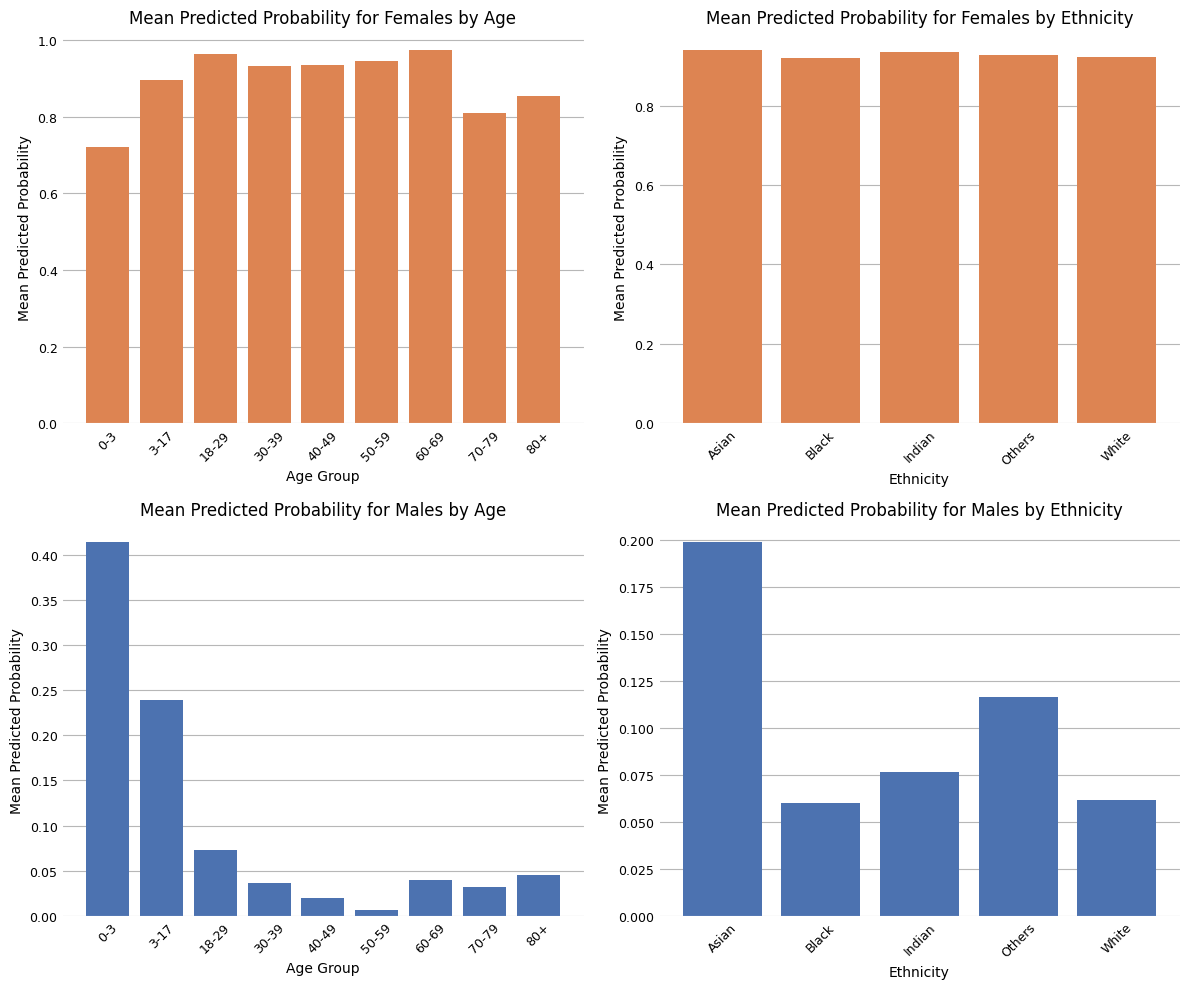

Proportion of females for age 0 to 3: 44.38%


In [19]:
female_data = face_predictions[face_predictions["Gender"] == "Female"]
male_data = face_predictions[face_predictions["Gender"] == "Male"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

age_grouped_female = female_data.groupby("Age Bin", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[0, 0].bar(age_grouped_female.index, age_grouped_female, color="#DD8452", zorder=2)
axes[0, 0].set_xlabel("Age Group")
axes[0, 0].set_ylabel("Mean Predicted Probability")
axes[0, 0].set_title("Mean Predicted Probability for Females by Age")
axes[0, 0].tick_params(axis="x", rotation=45)

ethnicity_grouped_female = female_data.groupby("Ethnicity", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[0, 1].bar(
    ethnicity_grouped_female.index, ethnicity_grouped_female, color="#DD8452", zorder=2
)
axes[0, 1].set_xlabel("Ethnicity")
axes[0, 1].set_ylabel("Mean Predicted Probability")
axes[0, 1].set_title("Mean Predicted Probability for Females by Ethnicity")
axes[0, 1].tick_params(axis="x", rotation=45)

age_grouped_male = male_data.groupby("Age Bin", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[1, 0].bar(age_grouped_male.index, age_grouped_male, color="#4C72B0", zorder=2)
axes[1, 0].set_xlabel("Age Group")
axes[1, 0].set_ylabel("Mean Predicted Probability")
axes[1, 0].set_title("Mean Predicted Probability for Males by Age")
axes[1, 0].tick_params(axis="x", rotation=45)

ethnicity_grouped_male = male_data.groupby("Ethnicity", observed=True)[
    "Predicted Gender Probs"
].mean()
axes[1, 1].bar(
    ethnicity_grouped_male.index, ethnicity_grouped_male, color="#4C72B0", zorder=2
)
axes[1, 1].set_xlabel("Ethnicity")
axes[1, 1].set_ylabel("Mean Predicted Probability")
axes[1, 1].set_title("Mean Predicted Probability for Males by Ethnicity")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

age_subset = face_predictions[(face_predictions["Age"] <= 3)]
proportion_females = (age_subset["Gender"] == "Female").mean()
print(f"Proportion of females for age 0 to 3: {proportion_females:.2%}")

- Probabilities are high for females and low for males, suggesting that the model is mostly fair in its predictions.
- Male babies have a high probability of being classified as female, while female babies have the highest probability among all female age groups of being classified as male. This is likely because distinguishing gender from baby faces is particularly difficult.  
- Compared to other age bins, toung males (up to 17) have a much higher chance of being categorized as female. 
- Asian men have a comparatively high probability of being classified as female, nearly twice as high as the next highest probability among other ethnicity groups.  

The detected biases may not have practical significance (except for male babies), as the final predictions would likely still be correct after applying a higher threshold. I could use multivariate analysis to get a clearer picture of whether specific subgroups are more affected by this bias. For example, Asian babies might experience the strongest age bias.  

## Reviewing Classification Errors

For conciseness, only the first nine error occurrences in the dataset are presented. 

First, let's check if the classification and regression outputs make errors on the same cases.

In [20]:
misclassified_gender = face_predictions[y_true_all != y_pred_all]
high_residuals = face_predictions[np.abs(face_predictions["Residuals"]) > 10]
overlapping_cases = pd.merge(misclassified_gender, high_residuals, on="image_path")
num_misclassified_gender = len(misclassified_gender)
num_high_residuals = len(high_residuals)
num_overlap = len(overlapping_cases)
gender_error_rate = (
    num_overlap / num_misclassified_gender * 100 if num_misclassified_gender else 0
)
age_error_rate = num_overlap / num_high_residuals * 100 if num_high_residuals else 0
explanation = (
    f"Total misclassified gender cases: {num_misclassified_gender}\n"
    f"Total high age residual cases (>10 years): {num_high_residuals}\n"
    f"Instances where both errors occurred: {num_overlap}\n"
    f"Percentage of gender misclassifications that also have high age residuals: {gender_error_rate:.2f}%\n"
    f"Percentage of high age residuals that also have gender misclassifications: {age_error_rate:.2f}%"
)
print(explanation)

Total misclassified gender cases: 146
Total high age residual cases (>10 years): 276
Instances where both errors occurred: 13
Percentage of gender misclassifications that also have high age residuals: 8.90%
Percentage of high age residuals that also have gender misclassifications: 4.71%


- The errors are mostly separate.

### Males Prdicted as Females

Nine images are presented for conciseness.

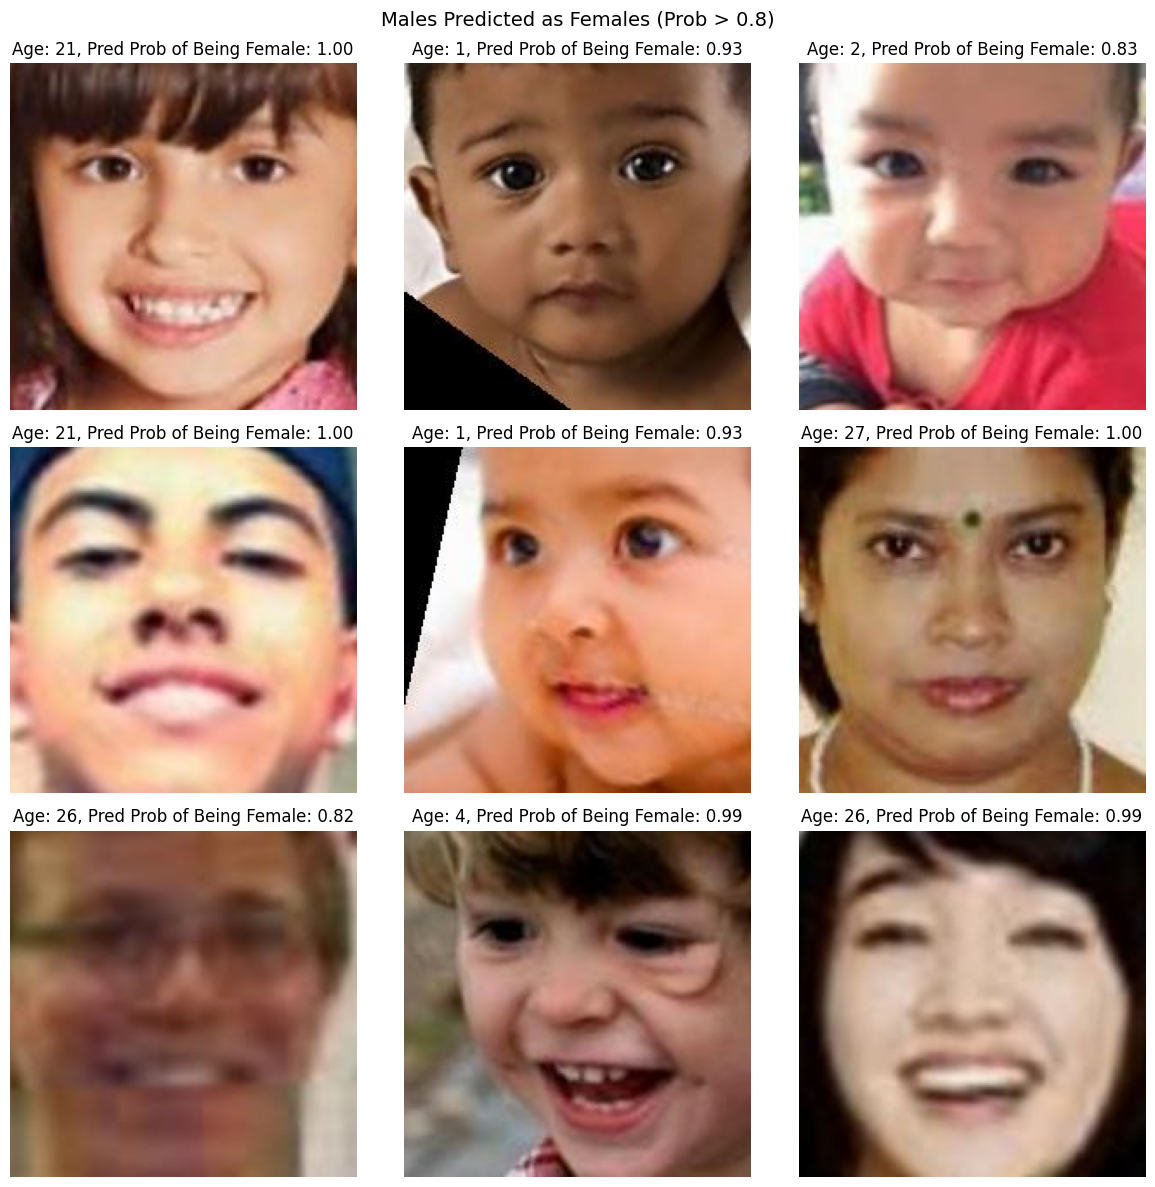

In [21]:
probability_threshold = 0.8
num_rows_display = 3
misclassified_males = face_predictions[
    (face_predictions["Gender"] == "Male")
    & (face_predictions["Predicted Gender Probs"] > probability_threshold)
]
plot_images_probability(
    misclassified_males,
    f"Males Predicted as Females (Prob > {probability_threshold})",
    num_rows_display,
)

- Most errors come from mislabeled data, babies, individuals with unclear facial features, and only a few genuine prediction mistakes.

### Females Predicted as Males

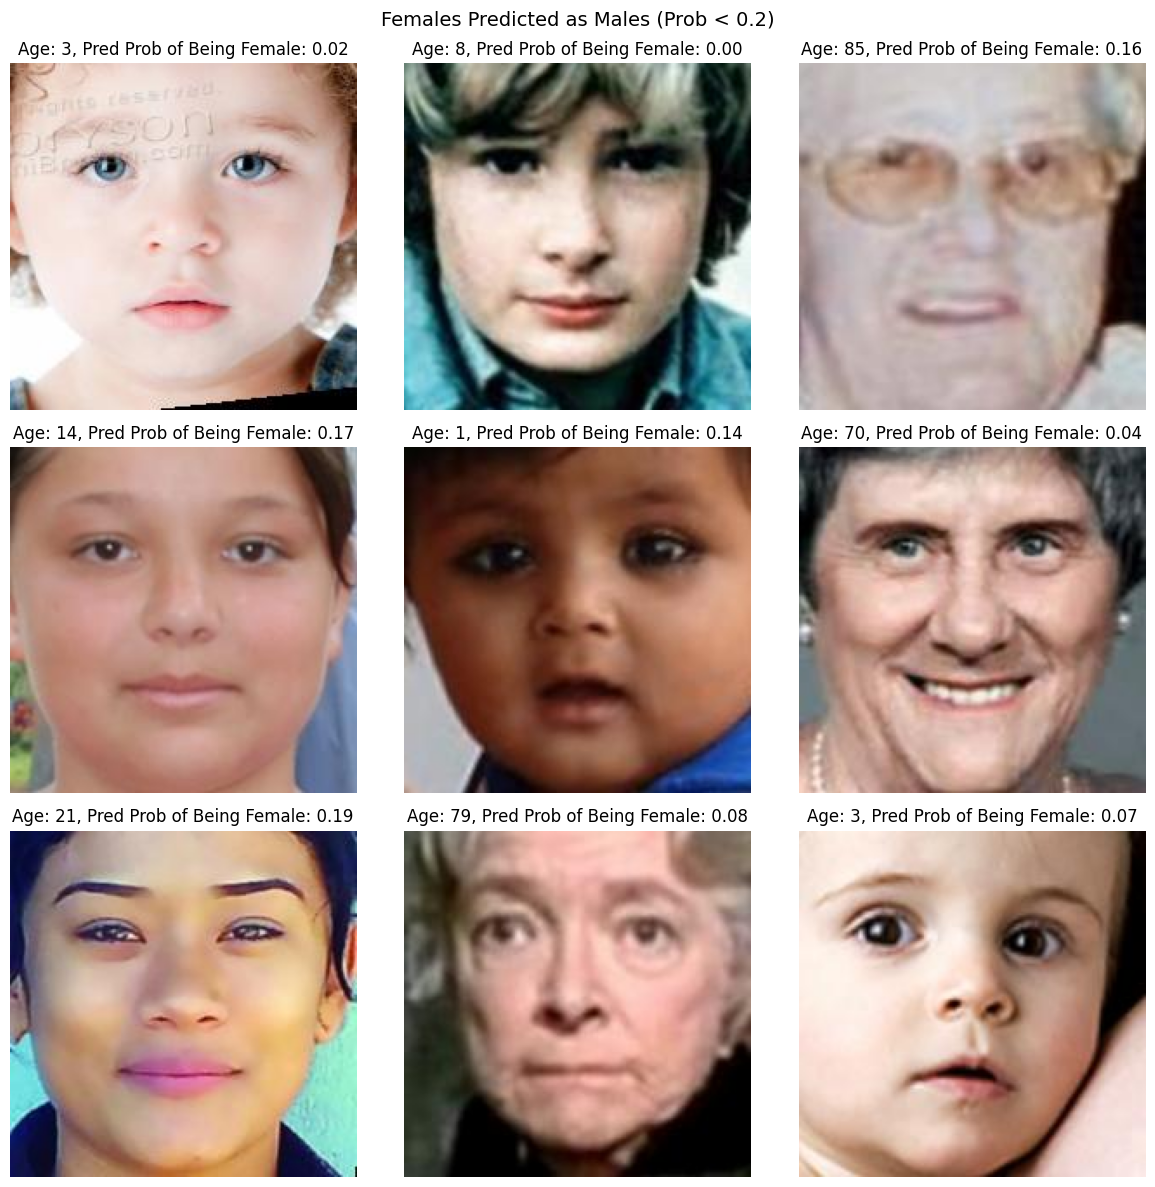

In [22]:
probability_threshold = 0.2
num_rows_display = 3
misclassified_females = face_predictions[
    (face_predictions["Gender"] == "Female")
    & (face_predictions["Predicted Gender Probs"] < probability_threshold)
]
plot_images_probability(
    misclassified_females,
    f"Females Predicted as Males (Prob < {probability_threshold})",
    num_rows_display,
)

- Mostly very young individuals, with a few androgynous faces.

### Summary of Errors

- The vast majority of errors involve predicting the gender of babies, which is often impossible even for humans.
- Many misclassifications occur with faces that lack clear gender cues.
- I've also reviewed uncertain predictions with probabilities between 0.3 and 0.7, but nothing new stood out.  

## LIME Analysis

LIME highlights the areas of an image that were most important for the model's prediction. Cyan areas support the predicted class, while red areas oppose it. Five images are presented for conciseness.

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

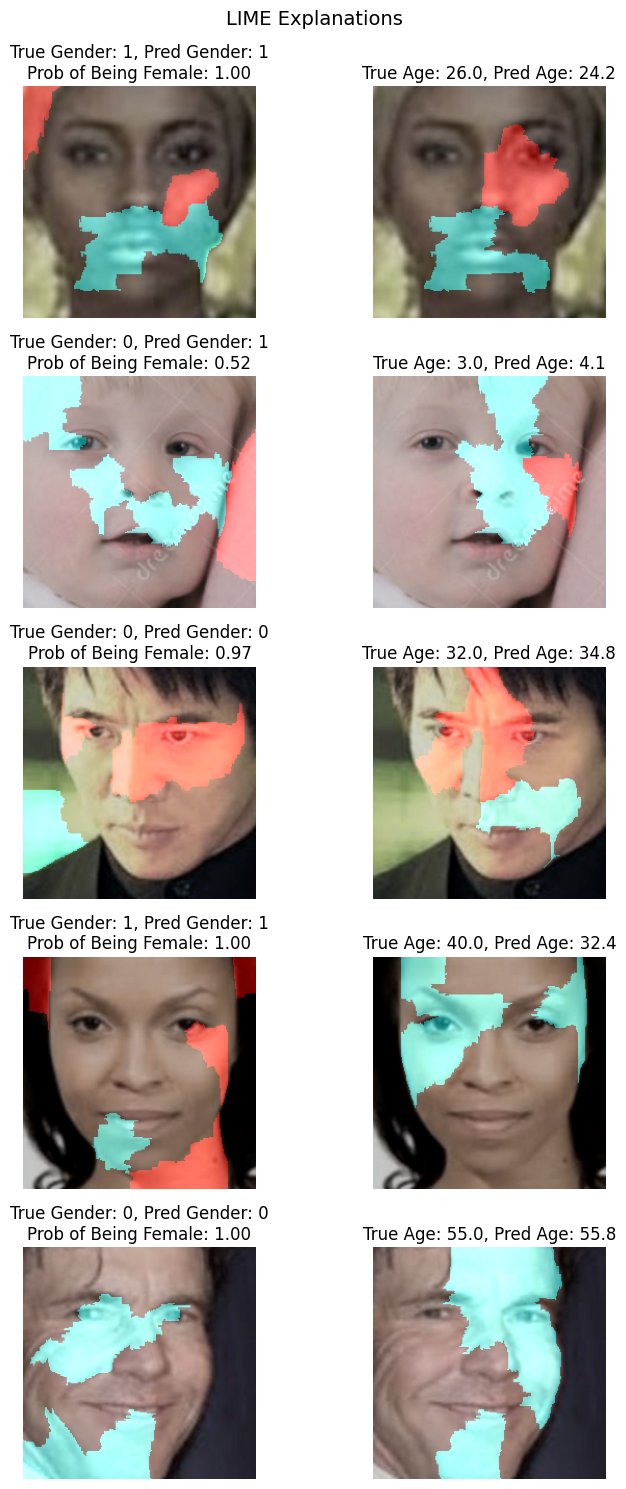

In [23]:
lime_plots_multitask(loaded_model, test_loader, 5)

- The model focuses on biologically relevant features such as the jawline, eyebrows, and lips.  
- For both correct and incorrect predictions, various regions of the face are used.  
- Sometimes model incorporates background information. Augmentations should be used to hide background.

# Conclusions

The model performs well, with an accuracy of 0.92, increasing to 0.95 when babies and toddlers are excluded, as their gender is generally harder to predict. A significant number of misclassifications come from incorrectly labeled data and androgynous faces. For age prediction, the model has an average error of 4.7 years, with variations of approximately ±1 year across gender and ethnicity subgroups, which is relatively small. In marketing applications, this level of accuracy should not be an issue, as a person's shopping preferences are likely to remain consistent within this range. However, for healthcare, this level of precision is probably not sufficient.  

#### Model Bias:

- Model underpredicts age for older individuals. This pattern is consistent across genders and ethnicities. The average error (MAE) is 8 years for those over 45, while for younger individuals (45 and below), it is 3.7 years.
- Compared to other age ranges, young males (up to 17) have a much higher chance of being categorized as female. 
- Asian men have a comparatively high probability of being classified as female, nearly twice as high as the next highest probability among other ethnicity groups.

#### Possible Bias Requiring Further Analysis:

- MAE varies across ethnicities, ranging from 5.4 to 3.7 years. Among Indian and "Other" ethnicities, males have an MAE higher than females by approximately 2 and 1 years. I could further assess whether the mistakes consistently lean in a particular direction. From the overlaid age residual scatterplots, it does not appear that that way, but the plots would need to be separated and inspected individually.  
- For young and Asian males, multivariate analysis could provide a clearer picture of whether specific subgroups are more affected by being categorizes as female. For example, Asian teenagers might be the ones categorizes as female. 
- Review images focusing on young and Asian males to determine whether they appear more feminine or if the bias comes from the model.   

#### Main Area for Improvement:  

- The dataset contains images of varying quality. Applying augmentations such as jitter, blur, contrast adjustment, brightness, saturation changes, sharpening could improve model performance.
- If I tested out the augmentations, I would try "VGGFace2", which is a ResNet50 that was fine-tuned on human bodies and faces.

#### If Fixing Old Age Underprediction Was a Priority:  

- Since older individuals are underrepresented, targeted data augmentation (such as synthetic aging) could improve model performance on this group.  
- MSE could be used as the loss function to better handle outlier age predictions. Another option is adding weight to the loss function to prioritize reducing age prediction error.

#### Further Data Exploration:

- Anomaly detection could be more thorough, especially for labels. The current check was quick.  
- For duplicate detection, if aggressive transformations such as heavy distortions or black-and-white conversions are applied, deep learning-based methods might be more effective.  
- Experiment with autoencoders to detect non-face images in the dataset. This is a low priority, as I later found only a single instance like this in the test dataset.  

#### Deployment:

- Since the dataset consists of close-up face images, real-world use would require cameras specifically targeting faces, which adds complexity as each person would need to be properly captured. However, the training set includes images of varied quality, making the model more adaptable to realistic conditions. 
- For deployment, ResNet18, which is smaller, could be used, as the difference in loss value between it and ResNet34 was only 0.3. For Local deployment a lighter model like ResNet18 is preferable for fast inference on limited resources. Server deployment should allow for the use of larger models for improved accuracy. This reduces hardware costs on the device but introduces latency and bandwidth costs. 
- Predicting ethnicity (race) can be very risky, even if the model is accurate, as many people are highly sensitive to this topic.  
- Classifying individuals into binary gender categories (male and female) can cause distress for users who identify differently.
- In marketing applications, face predictions made for a group of people like walkers by would need to be averaged or handled in another way.

#### Other Ideas:  

- Augmentations to hide background from images.
- Correct the gender and age labels or remove them. 
- More images, especially of older individuals.